# EDA — LGG Brain MRI Segmentation (Kaggle)

Goal:
- Understand file structure and pairing (image ↔ mask)
- Quantify tumor presence and mask area statistics
- Visualize samples + overlays
- Build a patient-level table (to avoid leakage later)


In [1]:
import os, re, glob, random, math
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

from PIL import Image

SEED = 42
random.seed(SEED)
np.random.seed(SEED)


In [2]:
# Kaggle usually mounts datasets here:
KAGGLE_INPUT = Path("/kaggle/input")

# Try common expected folder name first; otherwise scan for "kaggle_3m"
candidates = []
if KAGGLE_INPUT.exists():
    candidates = list(KAGGLE_INPUT.glob("**/kaggle_3m"))

print("Found candidates:", [str(p) for p in candidates[:10]])

if len(candidates) == 0:
    raise FileNotFoundError(
        "Could not find 'kaggle_3m' under /kaggle/input. "
        "Open the dataset page and attach the dataset to this notebook."
    )

DATA_ROOT = candidates[0]
DATA_ROOT


Found candidates: ['/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/kaggle_3m', '/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m']


PosixPath('/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/kaggle_3m')

In [3]:
patient_dirs = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])
print("DATA_ROOT:", DATA_ROOT)
print("Number of patient folders:", len(patient_dirs))
print("First 5 patient folders:", [p.name for p in patient_dirs[:5]])


DATA_ROOT: /kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/kaggle_3m
Number of patient folders: 110
First 5 patient folders: ['TCGA_CS_4941_19960909', 'TCGA_CS_4942_19970222', 'TCGA_CS_4943_20000902', 'TCGA_CS_4944_20010208', 'TCGA_CS_5393_19990606']


In [4]:
all_tifs = sorted(glob.glob(str(DATA_ROOT / "*" / "*.tif")))
mask_tifs = sorted([p for p in all_tifs if p.endswith("_mask.tif")])
img_tifs  = sorted([p for p in all_tifs if not p.endswith("_mask.tif")])

print("Total .tif files:", len(all_tifs))
print("Image .tif files:", len(img_tifs))
print("Mask  .tif files:", len(mask_tifs))

# Sanity checks
assert len(mask_tifs) > 0, "No mask files found."
assert len(img_tifs) > 0, "No image files found."


Total .tif files: 7858
Image .tif files: 3929
Mask  .tif files: 3929


In [5]:
def to_key(path):
    # Example:
    # .../TCGA_XXXX/TCGA_XXXX_YY.tif         -> key "TCGA_XXXX_YY"
    # .../TCGA_XXXX/TCGA_XXXX_YY_mask.tif    -> key "TCGA_XXXX_YY"
    base = Path(path).name
    if base.endswith("_mask.tif"):
        base = base.replace("_mask.tif", "")
    else:
        base = base.replace(".tif", "")
    return base

img_map = {to_key(p): p for p in img_tifs}
msk_map = {to_key(p): p for p in mask_tifs}

keys = sorted(set(img_map.keys()) & set(msk_map.keys()))
missing_img = sorted(set(msk_map.keys()) - set(img_map.keys()))
missing_msk = sorted(set(img_map.keys()) - set(msk_map.keys()))

print("Paired image-mask keys:", len(keys))
print("Masks without images:", len(missing_img))
print("Images without masks:", len(missing_msk))

if len(missing_img) > 0:
    print("Example missing image keys:", missing_img[:5])
if len(missing_msk) > 0:
    print("Example missing mask keys:", missing_msk[:5])

assert len(keys) > 0, "No paired image-mask items."


Paired image-mask keys: 3929
Masks without images: 0
Images without masks: 0


In [6]:
def patient_id_from_path(path):
    return Path(path).parent.name

df = pd.DataFrame({
    "key": keys,
    "image_path": [img_map[k] for k in keys],
    "mask_path":  [msk_map[k] for k in keys],
})
df["patient_id"] = df["image_path"].apply(patient_id_from_path)

# Attempt to extract slice number if present at end (common pattern: ..._12.tif)
def slice_index_from_key(k):
    m = re.search(r"_(\d+)$", k)
    return int(m.group(1)) if m else np.nan

df["slice_idx"] = df["key"].apply(slice_index_from_key)
df = df.sort_values(["patient_id", "slice_idx", "key"]).reset_index(drop=True)

df.head()


,key,image_path,mask_path,patient_id,slice_idx
0,TCGA_CS_4941_19960909_1,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,1
1,TCGA_CS_4941_19960909_2,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,2
2,TCGA_CS_4941_19960909_3,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,3
3,TCGA_CS_4941_19960909_4,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,4
4,TCGA_CS_4941_19960909_5,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,5


In [7]:
def load_tif(path):
    # Returns numpy array, uint8 typically
    arr = np.array(Image.open(path))
    return arr

# Inspect a few samples
sample_rows = df.sample(5, random_state=SEED)
for i, r in sample_rows.iterrows():
    img = load_tif(r.image_path)
    msk = load_tif(r.mask_path)
    print("Patient:", r.patient_id, "key:", r.key,
          "| img shape:", img.shape, img.dtype,
          "| msk shape:", msk.shape, msk.dtype,
          "| mask max:", msk.max())


Patient: TCGA_DU_8165_19970205 key: TCGA_DU_8165_19970205_2 | img shape: (256, 256, 3) uint8 | msk shape: (256, 256) uint8 | mask max: 0
Patient: TCGA_DU_7299_19910417 key: TCGA_DU_7299_19910417_29 | img shape: (256, 256, 3) uint8 | msk shape: (256, 256) uint8 | mask max: 0
Patient: TCGA_DU_A5TS_19970726 key: TCGA_DU_A5TS_19970726_9 | img shape: (256, 256, 3) uint8 | msk shape: (256, 256) uint8 | mask max: 255
Patient: TCGA_DU_7010_19860307 key: TCGA_DU_7010_19860307_24 | img shape: (256, 256, 3) uint8 | msk shape: (256, 256) uint8 | mask max: 255
Patient: TCGA_HT_A616_19991226 key: TCGA_HT_A616_19991226_25 | img shape: (256, 256, 3) uint8 | msk shape: (256, 256) uint8 | mask max: 0


In [8]:
def to_mask01(msk):
    # Some masks may be stored as 0/255; ensure 0/1
    if msk.ndim == 3:
        # If stored as RGB, reduce to single channel
        m = msk[..., 0]
    else:
        m = msk
    m = (m > 0).astype(np.uint8)
    return m

# Estimate unique values across a small subset
subset = df.sample(50, random_state=SEED)
vals = set()
for p in subset["mask_path"].tolist():
    m = load_tif(p)
    m01 = to_mask01(m)
    vals |= set(np.unique(m01).tolist())

vals


{0, 1}

In [9]:
def mask_stats(mask_path):
    m = to_mask01(load_tif(mask_path))
    area = int(m.sum())
    h, w = m.shape[:2]
    frac = area / float(h*w)
    present = int(area > 0)
    return present, area, frac, h, w

stats = df["mask_path"].apply(mask_stats)
df[["tumor_present", "mask_area_px", "mask_area_frac", "H", "W"]] = pd.DataFrame(stats.tolist(), index=df.index)

df.describe(include="all")


,key,image_path,mask_path,patient_id,slice_idx,tumor_present,mask_area_px,mask_area_frac,H,W
count,3929,3929,3929,3929,3929.000000,3929.000000,3929.000000,3929.000000,3929.0,3929.0
unique,3929,3929,3929,110,NaN,NaN,NaN,NaN,NaN,NaN
top,TCGA_HT_A61B_19991127_88,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_HT_A61A_20000127,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,1,88,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,21.561212,0.349453,674.943752,0.010299,256.0,256.0
std,NaN,NaN,NaN,NaN,15.904001,0.476858,1290.544368,0.019692,0.0,0.0
min,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,256.0,256.0
25%,NaN,NaN,NaN,NaN,9.000000,0.000000,0.000000,0.000000,256.0,256.0
50%,NaN,NaN,NaN,NaN,18.000000,0.000000,0.000000,0.000000,256.0,256.0
75%,NaN,NaN,NaN,NaN,30.000000,1.000000,821.000000,0.012527,256.0,256.0


In [10]:
summary = {
    "n_patients": df["patient_id"].nunique(),
    "n_slices_total": len(df),
    "tumor_slices": int(df["tumor_present"].sum()),
    "non_tumor_slices": int((1 - df["tumor_present"]).sum()),
    "tumor_slice_rate": float(df["tumor_present"].mean()),
    "image_size_unique": df[["H","W"]].drop_duplicates().shape[0],
}
summary


{'n_patients': 110,
 'n_slices_total': 3929,
 'tumor_slices': 1373,
 'non_tumor_slices': 2556,
 'tumor_slice_rate': 0.3494527869686943,
 'image_size_unique': 1}

In [11]:
patient_df = (df.groupby("patient_id")
              .agg(
                  n_slices=("key","count"),
                  tumor_slices=("tumor_present","sum"),
                  tumor_slice_rate=("tumor_present","mean"),
                  mean_mask_frac=("mask_area_frac","mean"),
                  max_mask_frac=("mask_area_frac","max"),
              )
              .reset_index()
              .sort_values(["tumor_slices","n_slices"], ascending=False))

patient_df.head(10)


,patient_id,n_slices,tumor_slices,tumor_slice_rate,mean_mask_frac,max_mask_frac
108,TCGA_HT_A61A_20000127,88,37,0.420455,0.009528,0.039246
35,TCGA_DU_7014_19860618,60,30,0.500000,0.017368,0.064178
32,TCGA_DU_7008_19830723,52,28,0.538462,0.021281,0.078812
33,TCGA_DU_7010_19860307,58,27,0.465517,0.015044,0.062973
31,TCGA_DU_6408_19860521,56,27,0.482143,0.022470,0.082428
62,TCGA_FG_5962_20000626,51,26,0.509804,0.015238,0.047531
109,TCGA_HT_A61B_19991127,88,25,0.284091,0.003927,0.024704
27,TCGA_DU_6401_19831001,51,25,0.490196,0.023988,0.085190
75,TCGA_FG_A60K_20040224,73,24,0.328767,0.001613,0.009598
72,TCGA_FG_8189_20030516,60,22,0.366667,0.011810,0.059906


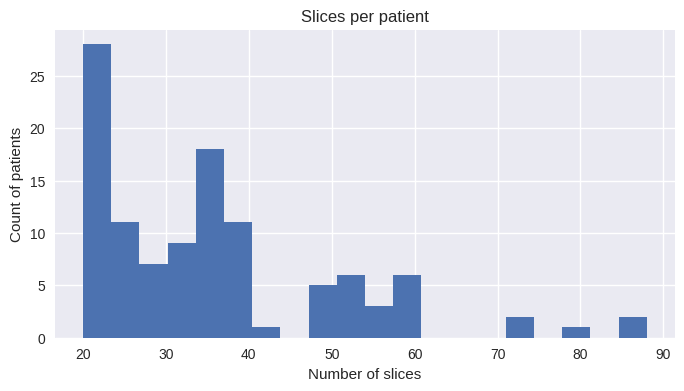

count    110.000000
mean      35.718182
std       15.193632
min       20.000000
25%       23.250000
50%       33.000000
75%       39.500000
max       88.000000
Name: n_slices, dtype: float64

In [12]:
plt.figure(figsize=(8,4))
plt.hist(patient_df["n_slices"], bins=20)
plt.title("Slices per patient")
plt.xlabel("Number of slices")
plt.ylabel("Count of patients")
plt.show()

patient_df["n_slices"].describe()


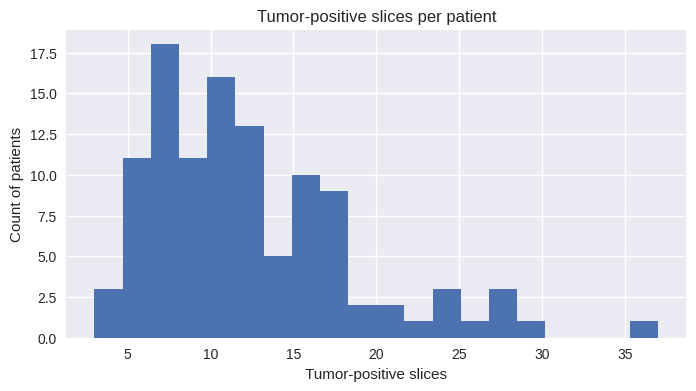

count    110.000000
mean      12.481818
std        6.233576
min        3.000000
25%        8.000000
50%       11.000000
75%       15.000000
max       37.000000
Name: tumor_slices, dtype: float64

In [13]:
plt.figure(figsize=(8,4))
plt.hist(patient_df["tumor_slices"], bins=20)
plt.title("Tumor-positive slices per patient")
plt.xlabel("Tumor-positive slices")
plt.ylabel("Count of patients")
plt.show()

patient_df["tumor_slices"].describe()


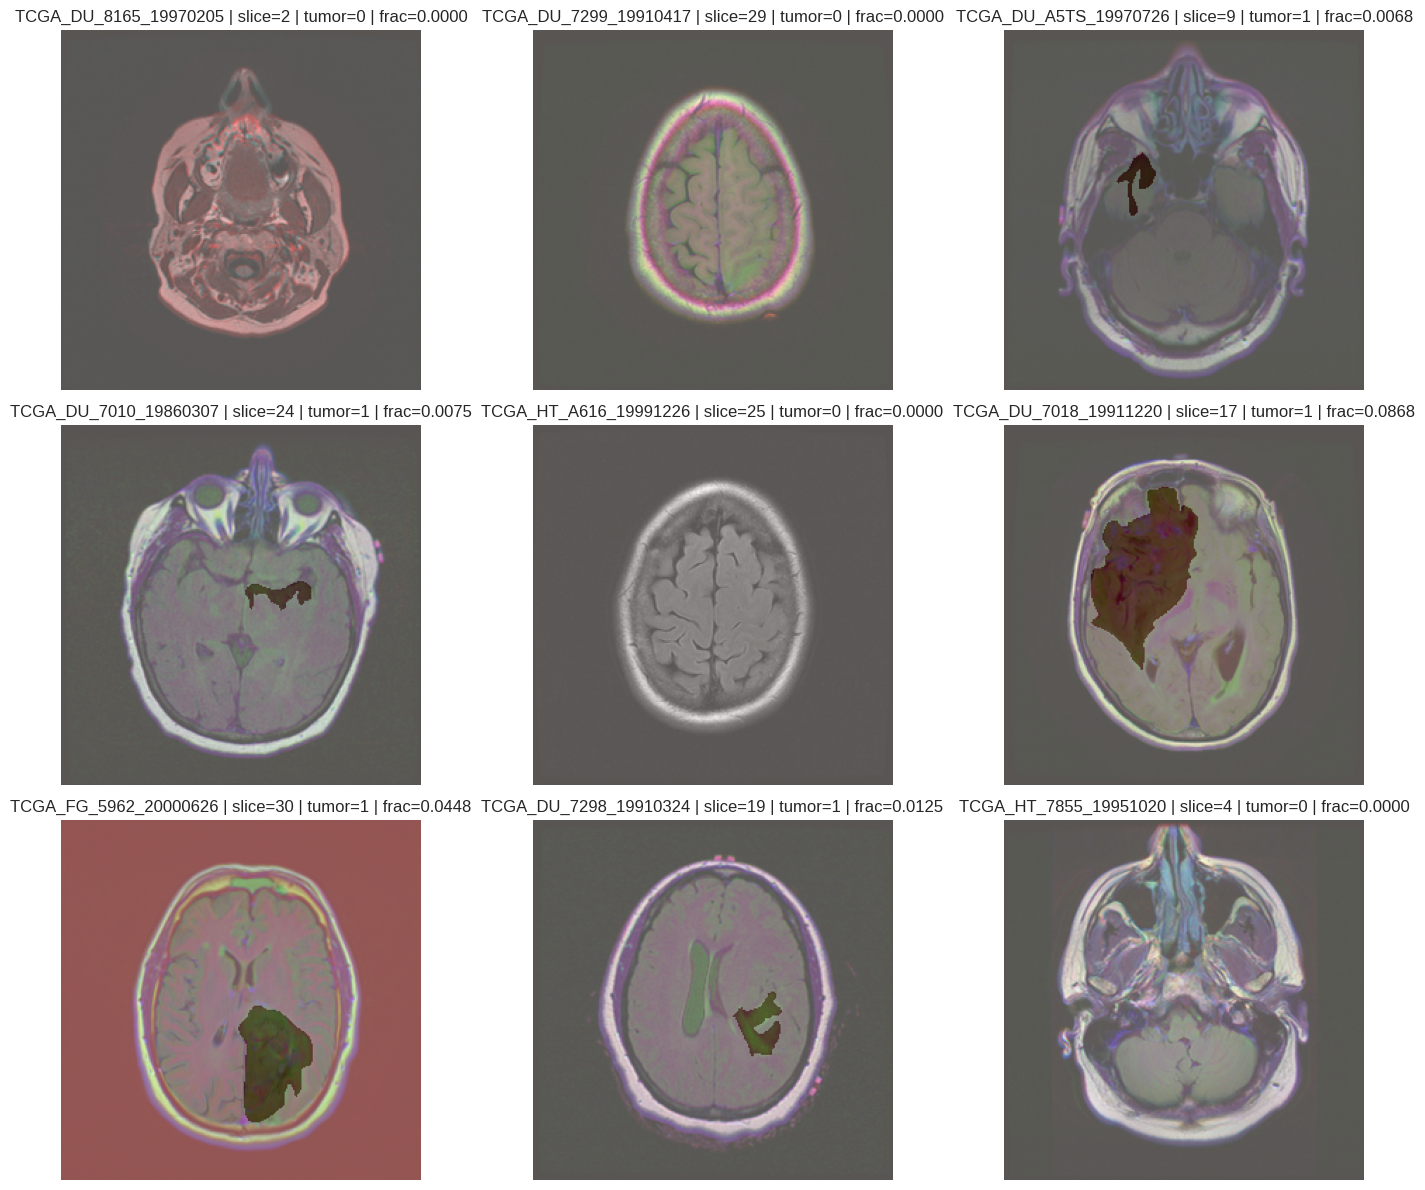

In [14]:
def normalize_img(img):
    # For display only
    x = img.astype(np.float32)
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    return x

def show_samples(df_in, n=6, only_tumor=False):
    d = df_in
    if only_tumor:
        d = d[d["tumor_present"]==1]
    d = d.sample(n=min(n, len(d)), random_state=SEED)

    ncols = 3
    nrows = math.ceil(len(d)/ncols)
    plt.figure(figsize=(5*ncols, 4*nrows))

    for i, (_, r) in enumerate(d.iterrows(), start=1):
        img = load_tif(r.image_path)
        msk = to_mask01(load_tif(r.mask_path))

        # display base image (if RGB, show as-is; else grayscale)
        plt.subplot(nrows, ncols, i)
        if img.ndim == 3:
            base = normalize_img(img)
            plt.imshow(base)
        else:
            plt.imshow(normalize_img(img), cmap="gray")

        # overlay mask
        plt.imshow(msk, cmap="Reds", alpha=0.35)
        plt.title(f"{r.patient_id} | slice={r.slice_idx} | tumor={r.tumor_present} | frac={r.mask_area_frac:.4f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_samples(df, n=9, only_tumor=False)


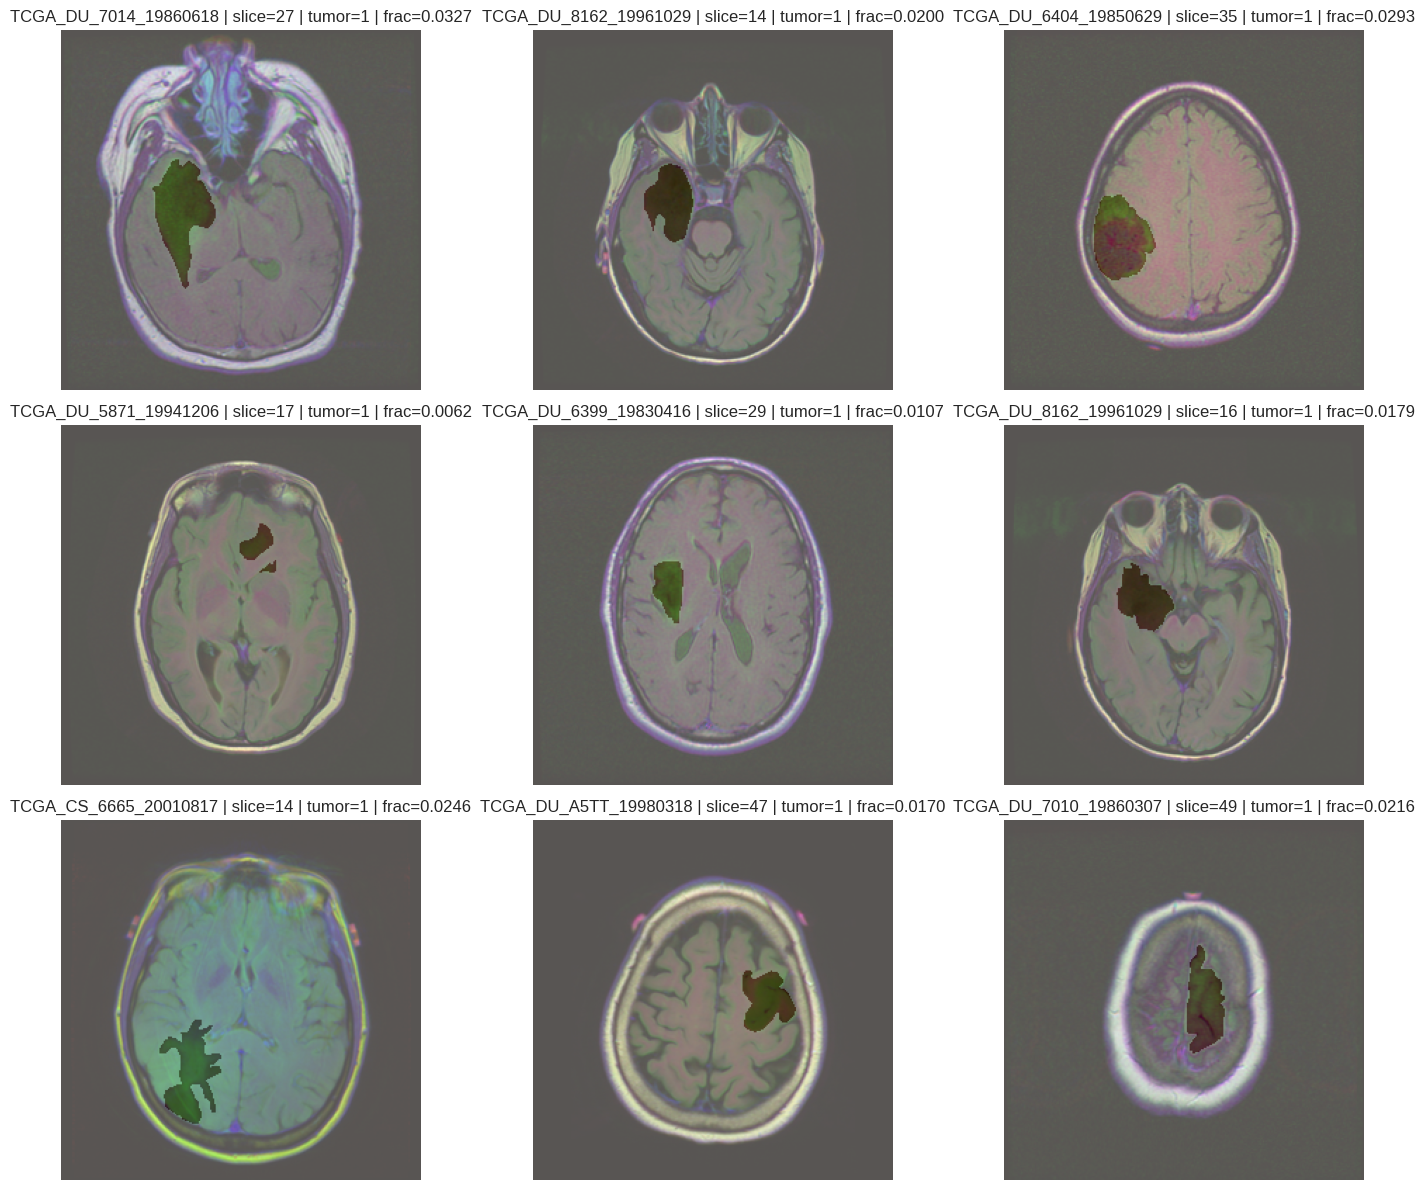

In [15]:
show_samples(df, n=9, only_tumor=True)


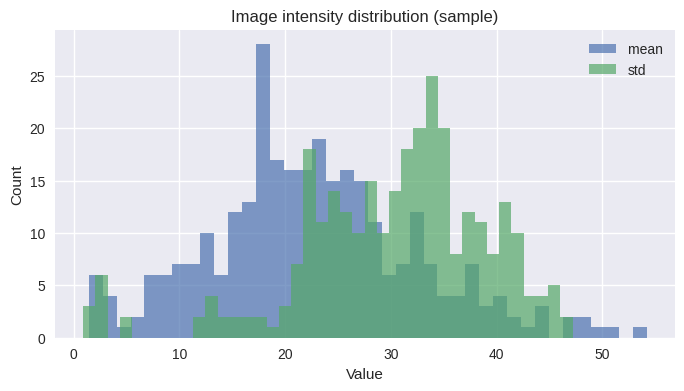

(array([ 1.42108667,  7.26864471, 21.68663502, 40.83429699, 54.18209457]),
 array([ 0.89290291, 13.37353005, 31.61161995, 42.50485153, 47.17070389]))

In [16]:
# Compute per-image mean/std for a sample to understand brightness/contrast range
sample = df.sample(300, random_state=SEED) if len(df) > 300 else df.copy()

means, stds = [], []
for p in sample["image_path"].tolist():
    img = load_tif(p)
    x = img.astype(np.float32)
    means.append(float(x.mean()))
    stds.append(float(x.std()))

plt.figure(figsize=(8,4))
plt.hist(means, bins=40, alpha=0.7, label="mean")
plt.hist(stds, bins=40, alpha=0.7, label="std")
plt.title("Image intensity distribution (sample)")
plt.xlabel("Value")
plt.ylabel("Count")
plt.legend()
plt.show()

np.percentile(means, [0, 5, 50, 95, 100]), np.percentile(stds, [0, 5, 50, 95, 100])


In [17]:
# Basic consistency checks
print("Any duplicate keys? ->", df["key"].duplicated().any())
print("Any duplicate image paths? ->", df["image_path"].duplicated().any())
print("Any duplicate mask paths? ->", df["mask_path"].duplicated().any())

# Verify image/mask sizes match (sample)
mismatch = 0
for _, r in df.sample(min(300, len(df)), random_state=SEED).iterrows():
    img = load_tif(r.image_path)
    msk = to_mask01(load_tif(r.mask_path))
    if img.shape[0] != msk.shape[0] or img.shape[1] != msk.shape[1]:
        mismatch += 1
mismatch


Any duplicate keys? -> False
Any duplicate image paths? -> False
Any duplicate mask paths? -> False


0

In [18]:
# NOTE: We'll only *save* splits here; training comes in another notebook.
# Split by patient_id to avoid slice leakage.
patients = patient_df["patient_id"].tolist()
rng = np.random.default_rng(SEED)
rng.shuffle(patients)

n = len(patients)
train_pat = patients[: int(0.8*n)]
val_pat   = patients[int(0.8*n): int(0.9*n)]
test_pat  = patients[int(0.9*n):]

split_map = {}
for pid in train_pat: split_map[pid] = "train"
for pid in val_pat:   split_map[pid] = "val"
for pid in test_pat:  split_map[pid] = "test"

df["split"] = df["patient_id"].map(split_map)

df["split"].value_counts(), df.groupby("split")["patient_id"].nunique()


(split
 train    3095
 test      428
 val       406
 Name: count, dtype: int64,
 split
 test     11
 train    88
 val      11
 Name: patient_id, dtype: int64)

In [19]:
OUT_DIR = Path("/kaggle/working/eda_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

df.to_csv(OUT_DIR / "lgg_master_slices.csv", index=False)
patient_df.to_csv(OUT_DIR / "lgg_patient_summary.csv", index=False)

print("Saved:")
print(" -", OUT_DIR / "lgg_master_slices.csv")
print(" -", OUT_DIR / "lgg_patient_summary.csv")


Saved:
 - /kaggle/working/eda_outputs/lgg_master_slices.csv
 - /kaggle/working/eda_outputs/lgg_patient_summary.csv


## Next notebook (Modeling)
Suggested next steps:
1) Build a PyTorch Dataset that loads image+mask, applies augmentations, returns tensors
2) Start with U-Net baseline (transfer-learning encoder), then add self-attention module
3) Use patient-level splits saved in `eda_outputs/`
4) Track Dice/IoU, calibration, and robustness
